In [11]:
import pandas as pd
import numpy as np
train_data = pd.read_csv('data/train.csv')
test_data = pd.read_csv('data/test.csv')
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [142]:
def sigmod(x):
    return 1.0 / (1.0 + np.exp(-x))

In [143]:
def relu(x):
    return np.maximum(0,x) #不能使用np.max()

In [14]:
test_ID = test_data['ID_code'].values

Text(0.5,1,'sigmod')

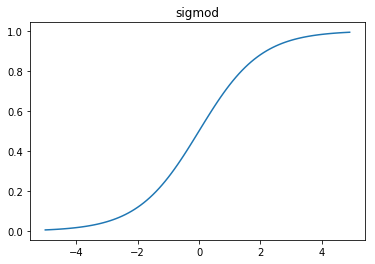

In [202]:
x = np.arange(-5,5,0.1)
y_sigmod = sigmod(x)
plt.plot(x,y_sigmod)
plt.title('sigmod')

Text(0.5,1,'relu')

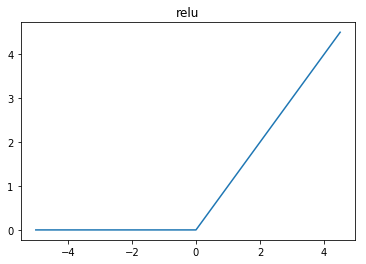

In [145]:
y_relu = relu(x)
plt.plot(x,y_relu)
plt.title('relu')

In [17]:
train_data.columns

Index(['ID_code', 'target', 'var_0', 'var_1', 'var_2', 'var_3', 'var_4',
       'var_5', 'var_6', 'var_7',
       ...
       'var_190', 'var_191', 'var_192', 'var_193', 'var_194', 'var_195',
       'var_196', 'var_197', 'var_198', 'var_199'],
      dtype='object', length=202)

### SGD
- 一般是mini-batch梯度下降算法
- 缺点是容易收敛到局部最优

In [18]:
target = train_data.target.values
train_data = train_data.drop(columns = ['ID_code','target'])
test_data = test_data.drop(columns = ['ID_code'])
scaler = StandardScaler() ## 进行归一化操作

In [19]:
train_data = scaler.fit_transform(train_data)
test_data = scaler.fit_transform(test_data)

In [251]:
test_data.shape

(200000, 200)

![bp](img/bp.png)

In [210]:
layers = [200,300,300,1]
params = {}
batch_size = 1000
def init_params():
    for i in range(1, len(layers)):
        params['w'+str(i) + str(i-1)] = np.random.standard_normal([layers[i],layers[i-1]])
        params['b'+str(i)] = np.zeros([layers[i],1])

In [211]:
init_params()

In [212]:
params['w10'].shape
params['b1'].shape
params['w21'].shape
params['b2'].shape
params['w32'].shape
params['b3'].shape

(1, 1)

In [213]:
def forward(X):
    cache = {}
    a = X.T
    cache['a' + '0'] = a
    for i in range(1,len(layers)):
        z = np.dot(params['w' + str(i) + str(i - 1)], a)
        z = z + params['b' + str(i)]
        if i == (len(layers) - 1):
            a = sigmod(z)
        else:
            a = relu(z)
        cache['z' + str(i)] = z
        cache['a' + str(i)] = a
    return cache

In [214]:
cache = forward(train_data[:100])
learning_rate = 1e-3

/Users/icdi/Desktop/py_ws/venv/lib/python3.5/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


In [215]:
## 反向传播
def back(cache,y):
    dz3 = cache['a3'] - y
    dw3 = 1 / batch_size * np.dot(dz3,cache['a2'].transpose())
    db3 = 1 / batch_size * np.sum(dz3 , axis = 1, keepdims = True)
    da2 = np.dot(params['w32'].transpose(), dz3) 
    
    dz2 = da2
    dz2[cache['z2'] < 0] = 0

    dw2 = 1 / batch_size * np.dot(dz2 ,cache['a1'].transpose())
    db2 = 1 / batch_size * np.sum(dz2 , axis = 1, keepdims = True)
    
    da1 = np.dot(params['w21'].transpose(), dz2) 
    dz1 = da1
    dz1[cache['z1'] < 0] = 0
    dw1 = 1 / batch_size * np.dot(dz1 ,cache['a0'].transpose())
    db1 = 1 / batch_size * np.sum(dz1 , axis = 1, keepdims = True)
    
    params['w32'] -= learning_rate * dw3
    params['b3'] -=learning_rate * db3
    params['w21'] -= learning_rate * dw2
    params['b2'] -= learning_rate * db2
    params['w10'] -=learning_rate * dw1
    params['b1'] -= learning_rate * db1

In [216]:
def get_loss(pred_y, y):
    pred_y[pred_y < 1e-8] = 1e-8
    pred_y[pred_y >= 1] = 0.99999
    result = - 1 / batch_size  * np.sum(y * np.log(pred_y) + (1.0 - y) * np.log(1.0 - pred_y))
    return result

In [217]:
N = train_data.shape[0]
iterator_num = 1000
loss_list = []
for i in range(iterator_num):
    start = (i * batch_size) % N
    end = start + batch_size
    cache = forward(train_data[start:end])
#     print(cache['a3'].shape,target[start:end].shape)
    loss_list.append(get_loss(np.squeeze(cache['a3']),target[start:end]))
    back(cache,target[start:end])

/Users/icdi/Desktop/py_ws/venv/lib/python3.5/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


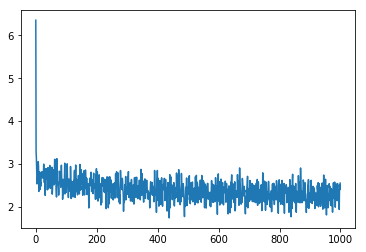

In [220]:
plt.plot(list(range(len(loss_list))), loss_list)
### 哎呀妈呀，目前是我想要的结果

In [219]:
np.min(loss_list)

1.7447206157764474

- 当数据量比较少的时候，可以直接使用所用数据进行梯度下降。
- 当数据量比较大的时候，可以使用mini_batch来训练数据。

In [253]:
############################### 
## 使用tensorflow 快速实现
import tensorflow  as tf
tf.reset_default_graph()
with tf.variable_scope("layer1"):
    w1 = tf.Variable(tf.random_normal([200,300], stddev = 1, seed = 1))
    b1 = tf.Variable(tf.random_normal([300], stddev = 1, seed = 1))

with tf.variable_scope("layer2"):
    w2 = tf.Variable(tf.random_normal([300,300], stddev = 1, seed = 1))
    b2 = tf.Variable(tf.random_normal([300], stddev = 1, seed = 1))

with tf.variable_scope("layer3"):
    w3 = tf.Variable(tf.random_normal([300,1], stddev = 1, seed = 1))
    b3 = tf.Variable(tf.random_normal([1], stddev = 1, seed = 1))

x = tf.placeholder(tf.float32, shape = (None,200),name = "x")
y_ = tf.placeholder(tf.float32, shape = (None, 1), name = "y")


In [309]:
### 定义操作
z1 = tf.add(tf.matmul(x,w1),b1)
a1 = tf.nn.tanh(z1)
z2 = tf.add(tf.matmul(a1,w2),b2)
a2 = tf.nn.tanh(z2)
z3 = tf.add(tf.matmul(a2,w3),b3)
y = tf.nn.sigmoid(z3)

In [310]:
### 定义loss
loss = - tf.reduce_mean(y_ * tf.log(tf.clip_by_value(y,1e-8,1.0)) + (1 - y_) * tf.log(tf.clip_by_value(1 - y,1e-8,1.0)))
# optimination = tf.train.GradientDescentOptimizer(0.001).minimize(loss)
optimination = tf.train.AdamOptimizer(0.001).minimize(loss)


In [311]:
batch_size = 2000
iterator = 2000
N = train_data.shape[0]
loss_list = []
with tf.Session() as sess:
    init_op = tf.global_variables_initializer()
    sess.run(init_op)
    for i in range(iterator):
#         print('iterator'+ str(i))
        start = (i * batch_size) % N
        end = min(N, start + batch_size)
        batch_data = train_data[start : end]
        batch_target = target[start : end].reshape(-1,1)
        sess.run(optimination, feed_dict = {x: batch_data , y_ : batch_target})
        loss_value = sess.run(loss, feed_dict = {x: batch_data , y_ : batch_target})
        loss_list.append(loss_value)
    result = sess.run(y, feed_dict = {x: test_data})
writer=tf.summary.FileWriter('./graph',sess.graph)

In [304]:
sub_df = pd.DataFrame({"ID_code": test_ID})
sub_df["target"]=result[:,0]
sub_df.to_csv("submission_nn.csv",index=False)

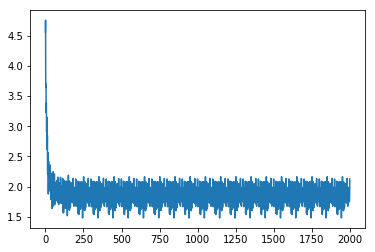

In [305]:
x_plt = range(len(loss_list))
plt.plot(x_plt,loss_list)

In [306]:
np.min(loss_list)

1.482865

In [307]:
## 使用where 实现 > 0.5时是1 ，小于时是0
y = tf.constant(0.4)
one = tf.ones_like(y)
zero = tf.zeros_like(y)
label = tf.cast(tf.where(tf.greater(y, 0.5), x=one, y=zero),tf.int32)
with tf.Session() as sess:
    print(sess.run(label))

0


In [8]:
list(range(4,1,-1))

[4, 3, 2]